
# Semi-Supervised ML
In the semi-supervised setting, a large unlabeled dataset and a small labeled dataset are given. The goal is to train a classifier on the entire dataset that would predict the labels of the unlabeled data points in the training set. This is called transductive semi-supervised learning. In the present problem, we have created a semi-supervised learning dataset consisting of $92\%$  unlabeled data points and $8\%$ labeled data points.

Using self-training semi-supervised learning method, we trained two base classifiers:

1. Logistic Regression 

2. Random Forest 

We use the ground truth (true lables) of the unlabeled dataset to validate the performance of the self-training semi-supervised learning models, but in reality the ground truth of the unlabeled data points will not be provided.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/ss_transfxns.py'
%run -i '../src/helper/ss_ml.py'
%run -i '../src/helper/sup_ml.py'

# Load data

In [3]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
df.head() # display the data

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,217.0,1445.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.00,0.00,0.0,0.0,0.01,0.01,n
1,0.0,343.0,3102.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.12,0.03,0.0,0.0,0.00,0.00,n
2,0.0,216.0,1800.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.01,0.01,0.0,0.0,0.00,0.00,n
3,0.0,320.0,1259.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.00,0.01,0.0,0.0,0.00,0.00,n
4,0.0,262.0,238.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.05,0.08,0.0,0.0,0.09,0.04,n


# Categorical variables encoded as integers

In [4]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Create feature matrix and class label

In [5]:
X, y = df.drop('v_29', axis = 1), df.v_29

# Create unlabeled dataset
In this section, we remove some labels and relabel them as unknown, which is indicated by -1

In [6]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [7]:
n_total_samples = len(y_)
n_labeled_points = 50000

#####################################################
indices = np.arange(n_total_samples)
unlabeled_set = indices[n_labeled_points:]

#####################################################
y_train = np.copy(y_)
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [8]:
print("Original class distribution")
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

Original class distribution


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [9]:
print("Class distribution for semi-supervised learning")
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()*100/len(y_train)
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

Class distribution for semi-supervised learning


,labels,count,percentage
0,unknown,570098,91.936758
1,normal,49921,8.050502
2,attack,79,0.012740


In [10]:
print(" Class distribution for true labels of the unlabeled dataset")
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

 Class distribution for true labels of the unlabeled dataset


,labels,count,percentage
0,normal,569125,99.829328
1,attack,973,0.170672


# Transformation pipeline

In [11]:
# Instantiate the class
transfxn = TransformationPipeline()

In [12]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [13]:
print('Training set size after pre-processing:', X_train_scaled.shape, y_train.shape)

Training set size after pre-processing: (620098, 33) (620098,)


#  Self-Training Semi-Supervised Learning

In [14]:
# Instantiate the class
model = SemiSupervised()

## A-1. Logistic Regression

In [15]:
lr_base_classifier = LogisticRegression(random_state = 42)
lr_y_pred, y_proba = model.self_training_clf(lr_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570087 new labels.
End of iteration 2, added 6 new labels.
End of iteration 3, added 2 new labels.
----------------------------------------
Predicted labels for 570098 unlabeled data points:


0    569139
1       959
dtype: int64

## A-1-1. Performance metrics

We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [16]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set], 
                        model_nm = 'Logistic Regression')

Test predictions for Logistic Regression
------------------------------------------------------------
Accuracy:  0.999954
AUROC: 0.989717
AUPRC: 0.973352
Predicted classes: [0 1]
Confusion matrix:
 [[569119      6]
 [    20    953]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569125
           1       0.99      0.98      0.99       973

    accuracy                           1.00    570098
   macro avg       1.00      0.99      0.99    570098
weighted avg       1.00      1.00      1.00    570098

------------------------------------------------------------


## A-1-2. PCA plot

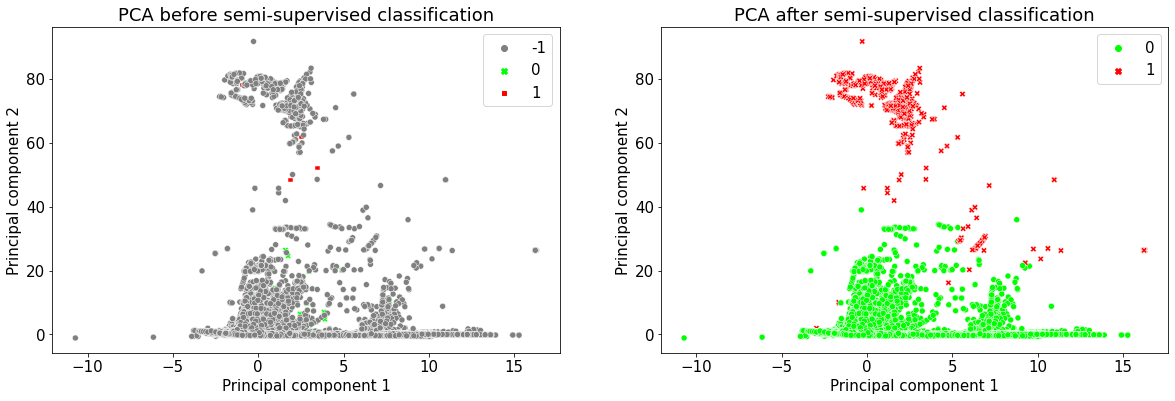

In [17]:
transfxn.plot_pca(X_train_scaled, y_train, lr_y_pred)

## A-2. Random Forest

In [18]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
rf_y_pred, y_proba = model.self_training_clf(rf_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570031 new labels.
End of iteration 2, added 17 new labels.
End of iteration 3, added 6 new labels.
End of iteration 4, added 4 new labels.
End of iteration 5, added 8 new labels.
End of iteration 6, added 5 new labels.
End of iteration 7, added 3 new labels.
End of iteration 8, added 3 new labels.
End of iteration 9, added 1 new labels.
----------------------------------------
Predicted labels for 570098 unlabeled data points:


0    569139
1       959
dtype: int64

## A-2-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [19]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set],
                     model_nm = 'Random Forest Classifier')

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.999972
AUROC: 0.992291
AUPRC: 0.983583
Predicted classes: [0 1]
Confusion matrix:
 [[569124      1]
 [    15    958]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569125
           1       1.00      0.98      0.99       973

    accuracy                           1.00    570098
   macro avg       1.00      0.99      1.00    570098
weighted avg       1.00      1.00      1.00    570098

------------------------------------------------------------


## A-2-2. PCA plot

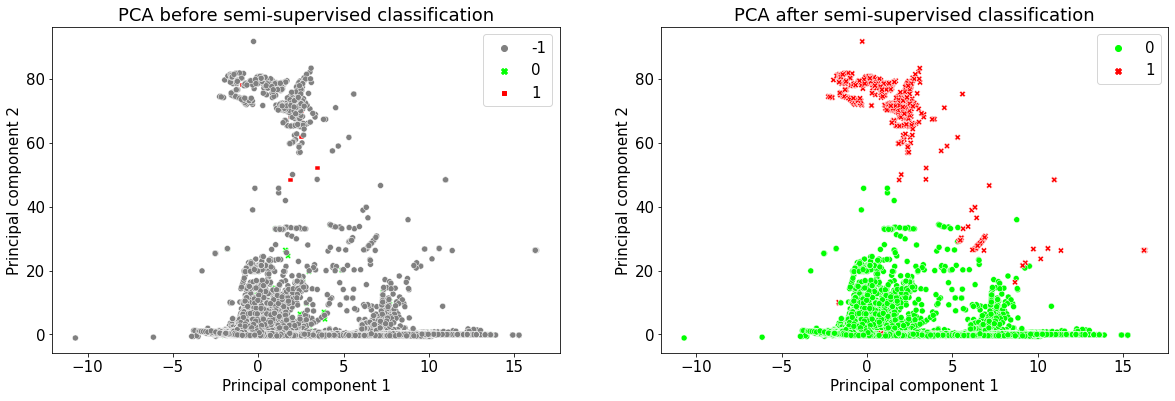

In [20]:
transfxn.plot_pca(X_train_scaled, y_train, rf_y_pred)

# Graph-Based Semi-Supervised Learning

## A-1. Label Spreading

In [ ]:
ls_y_pred, y_proba = model.label_spread(X_train_scaled, y_train, gamma = 20, max_iter = 30)

print('-' * 40)
print("Predicted labels for {} unlabeled data points:".format(len(y_true)))
pd.Series(ls_y_pred[unlabeled_set]).value_counts()

## A-1-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [ ]:
model.eval_metrics(y_true.values, ls_y_pred[unlabeled_set], model_nm = 'Label Spreading')